In [19]:
import torch.nn as nn
import torch
import os
import pandas as pd
import matplotlib.pyplot as plt

from train import load_data, eval
from models import *
from loss import leakage_loss
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import json
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [20]:
class AverageMeter(object):
    """
    Computes and stores the average and current value
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [21]:
data_path = "data/student_one_hot.csv"
checkpoint_path = "./checkpoints/student_vanilla_32c020a6"
config_path = checkpoint_path+"/config.json"
model_path = checkpoint_path+"/model.pkl"

In [22]:
with open(config_path, 'r') as file:
    config = json.load(file)

# Load from config
expr_name = config.get("expr_name")
data_fn = config.get("data_loc")
X_headers = config.get("x_headers")
C_headers = config.get("c_headers")
Y_headers = config.get("y_headers")
batch_size = config.get("batch_size", 1024)
Cy_norm = config.get("normalize", True)
latents = config.get("n_latent", 0)
label_loss_str = config.get("y_criterion", "bce")
loss_dict = {"bce": nn.BCELoss(), "bce_logits": nn.BCEWithLogitsLoss(), "mse": nn.MSELoss(),
            "leakage": leakage_loss, "cross_entropy": nn.CrossEntropyLoss()}
label_criterion = loss_dict.get(label_loss_str, nn.BCELoss())
label_weight = config.get("y_weight", 1)
concept_loss_str = config.get("c_criterion", "mse")
if isinstance(concept_loss_str, list):
    concept_criterion = []
    for criterion_str in concept_loss_str:
        concept_criterion.append(loss_dict.get(criterion_str, nn.MSELoss()))
else:
    concept_criterion = loss_dict.get(concept_loss_str, nn.MSELoss())
concept_weight = config.get("c_weight", 0.5)
latent_loss_str = config.get("l_criterion", None)
if not latent_loss_str:
    latent_criterion = None
else:
    latent_criterion = loss_dict.get(latent_loss_str, leakage_loss)
latent_weight = config.get("l_weight", 0)

x_to_c_params = config.get("x_to_c_model", dict())
xc_depth = x_to_c_params.get('depth', 4)
xc_width = x_to_c_params.get('width', 32)
xc_use_sigmoid = x_to_c_params.get('use_sigmoid', False)
xc_use_relu = x_to_c_params.get('use_relu', True if not xc_use_sigmoid else False)
xc_final_activation_str = x_to_c_params.get('final_activation', True)
activation_dict = {"relu": nn.ReLU(), "sigmoid": nn.Sigmoid(), "tanh": nn.Tanh(), "lrelu": nn.LeakyReLU()}
if isinstance(xc_final_activation_str, str):
    xc_final_activation = activation_dict.get(xc_final_activation_str, False)
else:
    xc_final_activation = xc_final_activation_str

c_to_y_params = config.get("c_to_y_model", dict())
cy_depth = c_to_y_params.get('depth', 3)
cy_width = c_to_y_params.get('width', 16)
cy_use_sigmoid = c_to_y_params.get('use_sigmoid', False)
cy_use_relu = c_to_y_params.get('use_relu', True if not cy_use_sigmoid else False)
cy_final_activation_str = c_to_y_params.get('final_activation', "sigmoid")
if isinstance(cy_final_activation_str, str):
    cy_final_activation = activation_dict.get(cy_final_activation_str, None)
else:
    cy_final_activation = cy_final_activation_str

n_concepts = len(C_headers)
y_criterion = label_criterion
y_weight = label_weight

In [23]:
_, test_loader, Cy_max = load_data(X_headers, C_headers, Y_headers, data_fn, Cy_norm=Cy_norm, batch_size=10**5)

x_to_c_model = XtoCModel(len(X_headers), len(C_headers), latents, depth=xc_depth, width=xc_width,
                         use_relu=xc_use_relu, use_sigmoid=xc_use_sigmoid, final_activation=xc_final_activation).to(device)
c_to_y_model = CtoYModel(len(C_headers)+latents, len(Y_headers), depth=cy_depth, width=cy_width,
                         use_relu=cy_use_relu, use_sigmoid=cy_use_sigmoid, final_activation=cy_final_activation).to(device)
model = FullModel(x_to_c_model, c_to_y_model).to(device)
model.load_state_dict(torch.load(model_path, weights_only=True))

<All keys matched successfully>

In [24]:
running_loss = AverageMeter()
running_accuracy = AverageMeter()
f1_score_meter = AverageMeter()
precision = AverageMeter()
recall = AverageMeter()
rocauc = AverageMeter()
concept_loss = AverageMeter()
model.eval()

for batch, data in enumerate(test_loader):
    X, Cy = data
    X = X.to(device)
    Cy = Cy.to(device)
    C = Cy[:,:n_concepts]
    y = Cy[:, n_concepts:]
    print(batch, X.shape[0])


    c_out, y_out = model(X)
    losses = []

    # Label Loss
    losses.append(y_weight * y_criterion(y_out, y))
    
    # Concept Loss
    if isinstance(concept_criterion, list):
        for i in range(len(concept_criterion)):
            if isinstance(concept_weight, list):
                c_weight = concept_weight[i]
            else:
                c_weight = concept_weight
            losses.append(c_weight * concept_criterion[i](c_out[:,i], C[:,i]))
    else:
        losses.append(concept_weight * concept_criterion(c_out[:,:n_concepts], C))
        
    # Latent Loss
    if latent_criterion:
        losses.append(latent_weight * latent_criterion(c_out[:,:n_concepts], c_out[:,n_concepts:]))
        
    loss = sum(losses)

    y_np = data[1][:, n_concepts:]
    y_pred = y_out.cpu().detach().numpy()
    y_pred_round = np.round(y_pred)
    batch_size_prop = X.shape[0]/test_loader.batch_size
    running_loss.update(loss.item(), batch_size_prop)
    running_accuracy.update(torch.mean((y == torch.round(y_out)).float()).item(), batch_size_prop)
    if np.array_equal(np.unique(y_np), [0,1]):
        f1_score_meter.update(f1_score(y_np, y_pred_round), batch_size_prop)
        precision.update(precision_score(y_np, y_pred_round), batch_size_prop)
        recall.update(recall_score(y_np, y_pred_round), batch_size_prop)
        rocauc.update(roc_auc_score(y_np, y_pred), batch_size_prop)
    concept_loss.update(sum(losses[1:1+n_concepts]).item()/n_concepts, batch_size_prop)


print("Test Results:")
print("Label Loss: {:.4f}, Accuracy: {:.4f}, Concept Loss: {:.4f}".format(running_loss.avg, running_accuracy.avg, concept_loss.avg))
print("F1 Score: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, ROCAUC: {:.4f}".format(f1_score_meter.avg, precision.avg, recall.avg, rocauc.avg))

0 195
Test Results:
Label Loss: 77.8532, Accuracy: 0.0000, Concept Loss: 0.0000
F1 Score: 0.0000, Precision: 0.0000, Recall: 0.0000, ROCAUC: 0.0000


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,...,guardian_father,guardian_mother,guardian_other,schoolsup,famsup,paid,activities,nursery,higher,G3
0,1.0,0.0,16.0,0.0,1.0,0.0,1.0,3.0,1.0,1.0,...,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,8.000000
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.999215,0.995368,0.663349,0.998718,0.990881,0.996654,3.721530
2,1.0,1.0,19.0,0.0,1.0,0.0,3.0,3.0,1.0,2.0,...,0.0,0.0,1.0,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,12.000000
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.999953,0.999462,0.697817,0.999916,0.998640,0.999624,3.737236
4,1.0,0.0,17.0,1.0,1.0,0.0,3.0,4.0,3.0,2.0,...,0.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,10.000000
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.999796,0.998333,0.681493,0.999612,0.996264,0.998677,3.731107
6,1.0,0.0,15.0,0.0,1.0,0.0,4.0,4.0,2.0,2.0,...,0.0,1.0,0.0,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,15.000000
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.999368,0.996013,0.668792,0.998854,0.991955,0.996855,3.723826
8,1.0,1.0,18.0,0.0,0.0,0.0,3.0,3.0,1.0,4.0,...,0.0,1.0,0.0,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,15.000000
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.999690,0.997846,0.680512,0.999461,0.995027,0.998340,3.729935


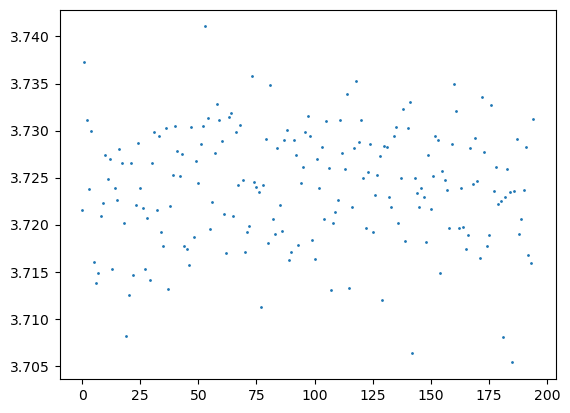

In [28]:
outputs = c_out.cpu().detach().numpy()* np.max(C.cpu().detach().numpy(), axis=0)
inputs_empty = np.empty(X.shape)
inputs_empty.fill(np.nan)
labels_out = y_out.cpu().detach().numpy()
outputs_full = np.concatenate((outputs , labels_out), axis=1)
predictions = np.concatenate((inputs_empty, outputs_full), axis=1)
inputs_test = np.concatenate((X.cpu().detach().numpy(), Cy.cpu().detach().numpy()), axis=1) # inputs_test
result = np.hstack([inputs_test,predictions])
result = result.reshape((predictions.shape[0]*2, predictions.shape[1]))
test_headers = list(X_headers)
test_headers.extend(C_headers)
test_headers.extend(Y_headers)
df_test = pd.DataFrame(result, columns=test_headers)
with pd.option_context('display.max_rows', 20):
    display(df_test.head(20))
plt.scatter(range(y_out.shape[0]), labels_out,s=1)
plt.show()

<Figure size 1400x1400 with 0 Axes>

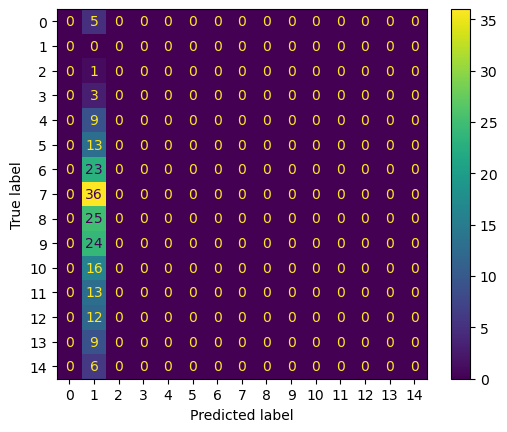

In [26]:
cm = confusion_matrix(y_np, y_pred_round)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure(figsize=(14,14))
disp.plot()
plt.show()

In [27]:
college_levels = np.unique(data[0][:, X_headers.index("collegeLevel")])
index = np.in1d(data[0][:, X_headers.index("collegeLevel")], [college_levels[3]])
y_test2 = y_np[index,-1]
y_pred2 = y_pred_round[index]
cm = confusion_matrix(y_test2, y_pred2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

ValueError: 'collegeLevel' is not in list